# MARKETING CAMPAIGN DATASET ANALYSIS

In [0]:
#importing necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import scipy.stats as s
import seaborn as sns

## 1)Reading Data

In [0]:
# Reading Data

from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("Read CSV").getOrCreate()

# Read the CSV file and create a DataFrame
data = spark.read.csv("/FileStore/tables/bank_data_mod-3.csv", header=True, inferSchema=True)


In [0]:
# Printing Data
data.head()

Out[4]: Row(age=30, job='unemployed', marital='married', education='primary', default='no', balance=1787, housing='no', loan='no', contact='cellular', day=19, month='oct', duration=79, campaign=1, pdays=-1, previous=0, poutcome='unknown', y='no')

## 2)Printing Schema with Data Types

In [0]:
#Printing Schema Of Data
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



## 3)Check Missing Data or Null Values

In [0]:
#Checking null values if Exists

from pyspark.sql.functions import isnull, sum

# Count the number of missing values in each column
null_counts = data.select([sum(isnull(c).cast("int")).alias(c) for c in data.columns]).show()


+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|  0|  0|      0|        0|      0|      0|      0|   0|      0|  0|    0|       0|       0|    0|       0|       0|  0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+



In [0]:
#No need to run any null command to drop any nul values

## 4)Check for Data Quality Issues of Categorical Variables

#### A) Understanding Job domains and their impact of domain on campaign subscription

In [0]:
data.describe('job').show()

+-------+-------+
|summary|    job|
+-------+-------+
|  count|   4521|
|   mean|   null|
| stddev|   null|
|    min| admin.|
|    max|unknown|
+-------+-------+



You can display all the unique values and based on domain kbowledge can decide if incrrect data exists or not.

In [0]:
#Understanding job roles

from pyspark.sql.functions import col

# Get an array of unique values in the 'job' column
job_unique = data.select("job").distinct().rdd.flatMap(lambda x: x).collect()
print(job_unique)


['management', 'retired', 'unknown', 'self-employed', 'student', 'blue-collar', 'entrepreneur', 'admin.', 'technician', 'services', 'housemaid', 'unemployed']


+-------------+---+-----+
|          job|  Y|count|
+-------------+---+-----+
|       admin.| no|  420|
|      retired|yes|   54|
|   management| no|  838|
|  blue-collar| no|  877|
|      student| no|   65|
|      unknown| no|   31|
|   technician| no|  685|
|       admin.|yes|   58|
|   management|yes|  131|
|  blue-collar|yes|   69|
|      unknown|yes|    7|
|   unemployed| no|  115|
|self-employed|yes|   20|
|   unemployed|yes|   13|
|    housemaid|yes|   14|
|   technician|yes|   83|
|     services|yes|   38|
|self-employed| no|  163|
|    housemaid| no|   98|
| entrepreneur|yes|   15|
+-------------+---+-----+
only showing top 20 rows



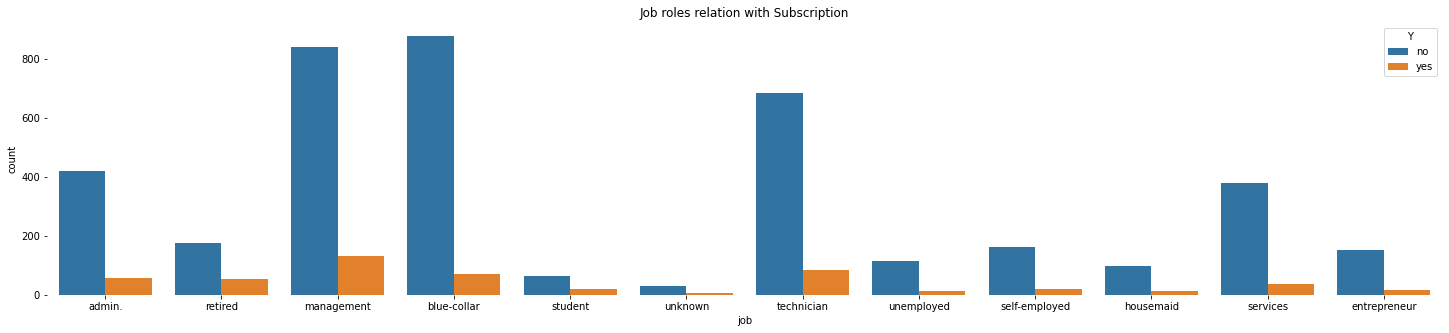

In [0]:
#Examining the response of "Job Domains" with "Subscription"

df1=data[['job', 'Y']]
JobCount = df1.groupBy("job","Y").count()
JobCount.show()
 
 
#Let's see how 'Job roles' are related to Subscription
f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='job', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='job', ylabel='count', title = 'Job roles relation with Subscription')
plt.show()

In [0]:
# It is observed from the below plotted graph that Customers having Jobs in "Management", "Technicians", "Admin" are most likely to subscribed  

#### B) Understanding Marital status their impact on campaign subscription

In [0]:
data.describe('marital').show()


+-------+--------+
|summary| marital|
+-------+--------+
|  count|    4521|
|   mean|    null|
| stddev|    null|
|    min|divorced|
|    max|  single|
+-------+--------+



+--------+---+-----+
| marital|  Y|count|
+--------+---+-----+
|divorced|yes|   77|
|  single| no| 1029|
|  single|yes|  167|
|divorced| no|  451|
| married|yes|  277|
| married| no| 2520|
+--------+---+-----+



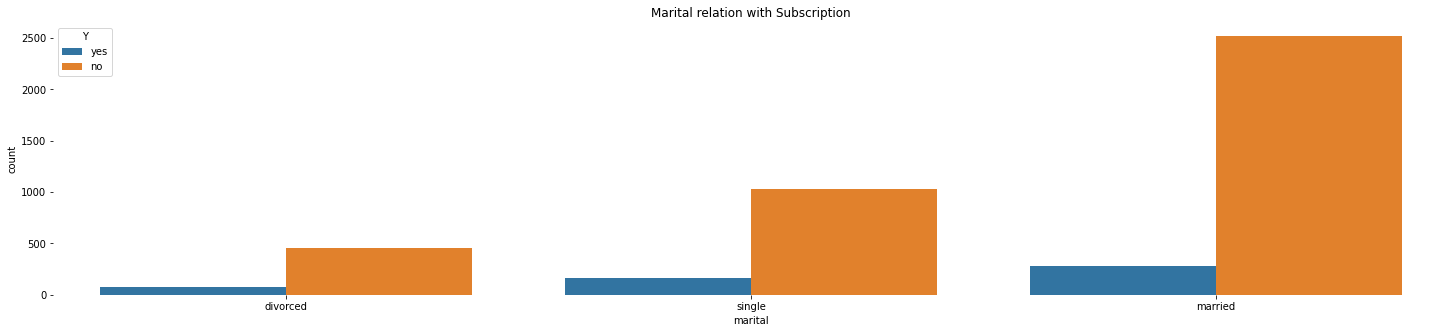

In [0]:
#Examining the response of "Marital Status" with "Subscription"

df1=data[['marital', 'Y']]
JobCount = df1.groupBy("marital","Y").count()
JobCount.show()
 

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='marital', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='marital', ylabel='count', title = 'Marital relation with Subscription')
plt.show()

In [0]:
# It is observed from the above plotted graph that Customers having Jobs in who are married usually likely to declined subscription  

#### C) Understanding Education and their impact on campaign subscription

In [0]:
data.describe('education').show()

+-------+---------+
|summary|education|
+-------+---------+
|  count|     4521|
|   mean|     null|
| stddev|     null|
|    min|  primary|
|    max|  unknown|
+-------+---------+



+---------+---+-----+
|education|  Y|count|
+---------+---+-----+
|  unknown| no|  168|
| tertiary| no| 1157|
|secondary| no| 2061|
|  unknown|yes|   19|
|  primary| no|  614|
|  primary|yes|   64|
|secondary|yes|  245|
| tertiary|yes|  193|
+---------+---+-----+



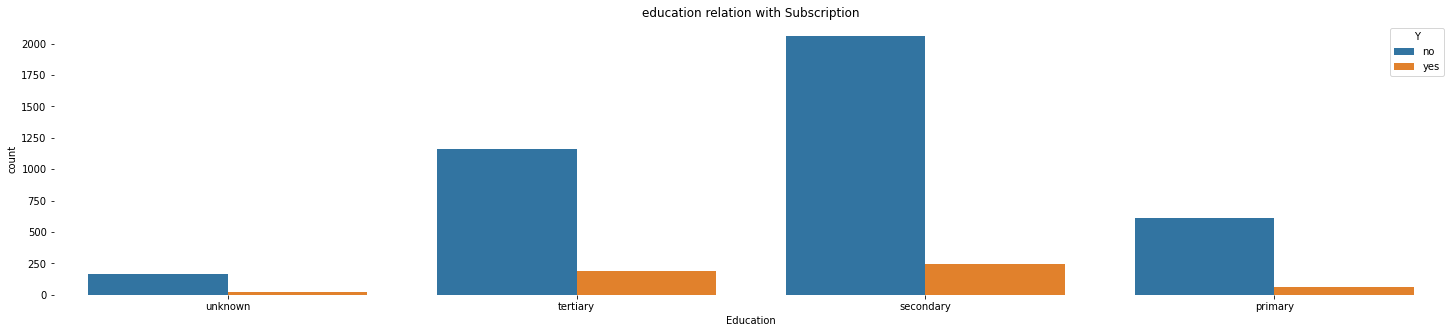

In [0]:
#Examining the response of "Educatioon" with "Subscription"

df1=data[['education', 'Y']]
JobCount = df1.groupBy("education","Y").count()
JobCount.show()
 
f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='education', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Education', ylabel='count', title = 'education relation with Subscription')
plt.show()

#### D) Understanding Housing Loan and their impact on campaign subscription

In [0]:
data.describe('housing').show()

+-------+-------+
|summary|housing|
+-------+-------+
|  count|   4521|
|   mean|   null|
| stddev|   null|
|    min|     no|
|    max|    yes|
+-------+-------+



+-------+---+-----+
|housing|  Y|count|
+-------+---+-----+
|     no| no| 1661|
|     no|yes|  301|
|    yes|yes|  220|
|    yes| no| 2339|
+-------+---+-----+



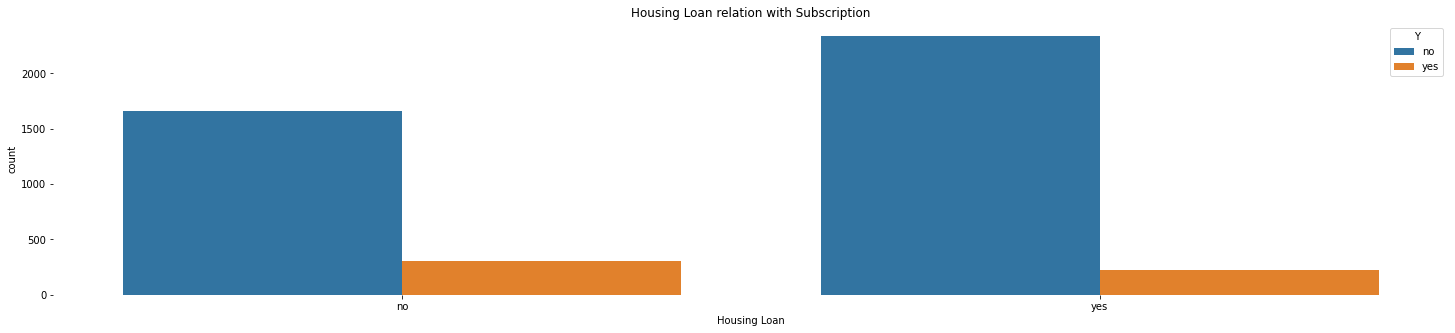

In [0]:
#Examining the response of "Housing Loan" with "Subscription"

df1=data[['housing', 'Y']]
JobCount = df1.groupBy("housing","Y").count()
JobCount.show()
 

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='housing', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Housing Loan', ylabel='count', title = 'Housing Loan relation with Subscription')
plt.show()

In [0]:
# It is observed from the above plotted graph that Customers having housing loan usually declined to subscribe service.

#### E) Understanding "Personal loan" and their impact on campaign subscription

In [0]:
# Here Housing means, does customer have housing loan? 

data.describe('loan').show()

+-------+----+
|summary|loan|
+-------+----+
|  count|4521|
|   mean|null|
| stddev|null|
|    min|  no|
|    max| yes|
+-------+----+



+----+---+-----+
|loan|  Y|count|
+----+---+-----+
|  no| no| 3352|
|  no|yes|  478|
| yes|yes|   43|
| yes| no|  648|
+----+---+-----+



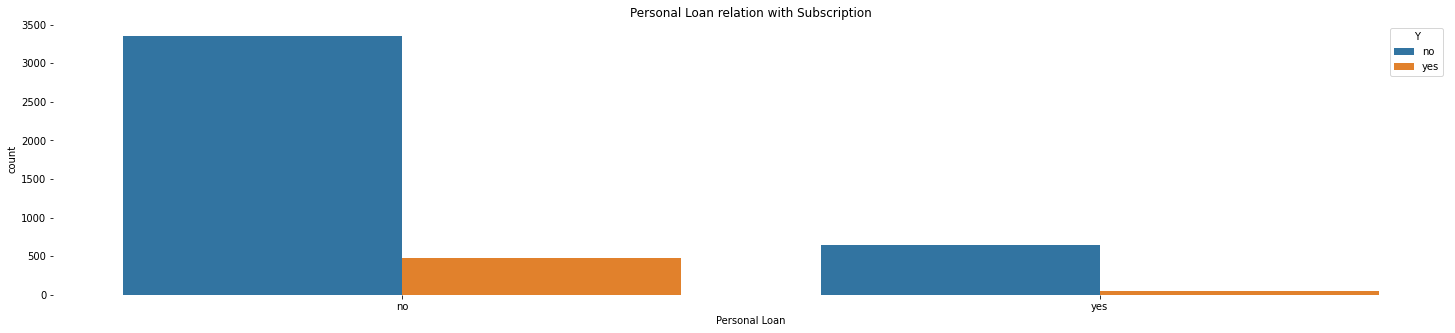

In [0]:
#Examining the response of "Personal Loan" with "Subscription"

df1=data[['loan', 'Y']]
JobCount = df1.groupBy("loan","Y").count()
JobCount.show()
 
f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='loan', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Personal Loan', ylabel='count', title = 'Personal Loan relation with Subscription')
plt.show()

In [0]:
# It is observed from the above plotted graph that Customers dont having Personal loan usually likely to subscribe service.

#### F) Understanding "Way of contact in last campaign" and their impact on campaign subscription

In [0]:
# Here contact means, thru which way customer have been contacted in last campaign? 

data.describe('contact').show()

+-------+--------+
|summary| contact|
+-------+--------+
|  count|    4521|
|   mean|    null|
| stddev|    null|
|    min|cellular|
|    max| unknown|
+-------+--------+



+---------+---+-----+
|  contact|  Y|count|
+---------+---+-----+
| cellular| no| 2480|
|  unknown| no| 1263|
|telephone|yes|   44|
|  unknown|yes|   61|
|telephone| no|  257|
| cellular|yes|  416|
+---------+---+-----+



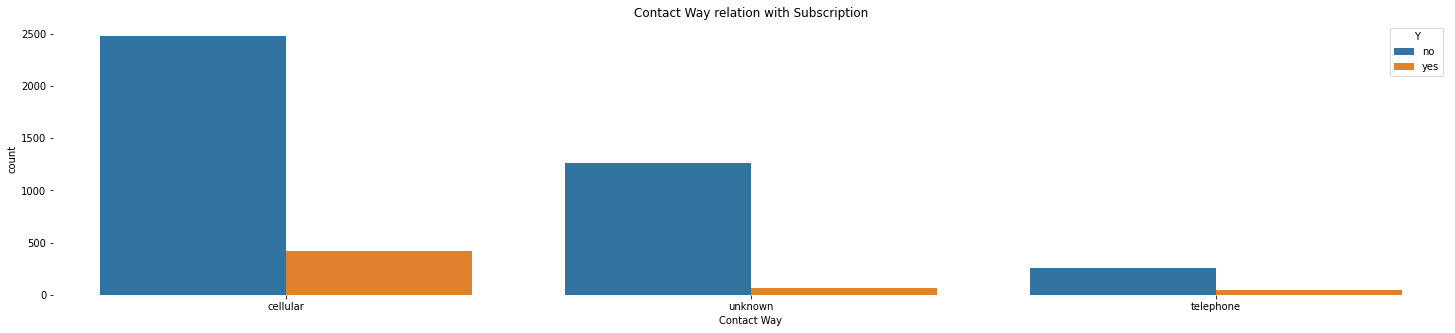

In [0]:
df1=data[['contact', 'Y']]
JobCount = df1.groupBy("contact","Y").count()
JobCount.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='contact', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Contact Way', ylabel='count', title = 'Contact Way relation with Subscription')

plt.show()

In [0]:
#Its been observed that customer who have been approached using cellular are likely to respond

#### G) Understanding "In which month we have contact customer during last campaign" and their impact on campaign subscription

In [0]:
data.describe('month').show()

+-------+-----+
|summary|month|
+-------+-----+
|  count| 4521|
|   mean| null|
| stddev| null|
|    min|  apr|
|    max|  sep|
+-------+-----+



+-----+---+-----+
|month|  Y|count|
+-----+---+-----+
|  sep| no|   35|
|  dec| no|   11|
|  jul| no|  645|
|  oct| no|   43|
|  sep|yes|   17|
|  jun|yes|   55|
|  nov| no|  350|
|  aug|yes|   79|
|  may| no| 1305|
|  feb|yes|   38|
|  mar| no|   28|
|  dec|yes|    9|
|  jun| no|  476|
|  apr| no|  237|
|  aug| no|  554|
|  mar|yes|   21|
|  jan| no|  132|
|  nov|yes|   39|
|  jan|yes|   16|
|  jul|yes|   61|
+-----+---+-----+
only showing top 20 rows



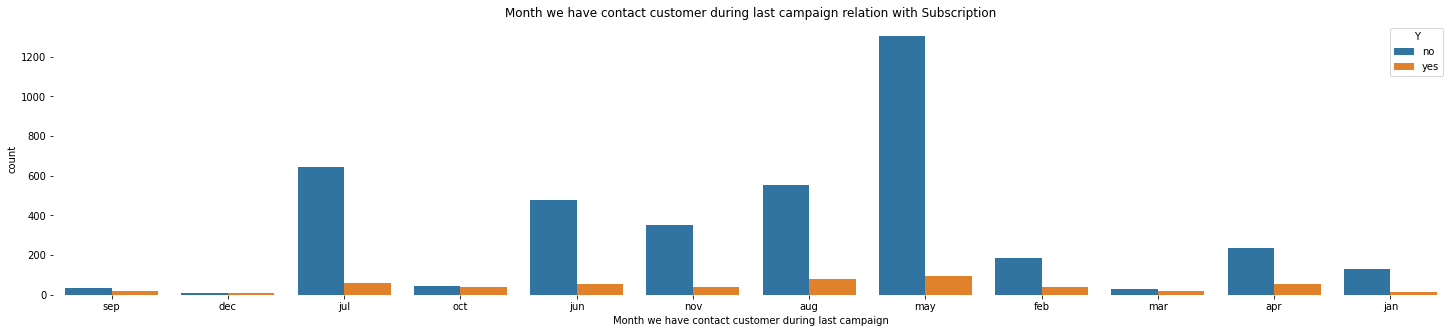

In [0]:
df1=data[['month', 'Y']]
JobCount = df1.groupBy("month","Y").count()
JobCount.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='month', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Month we have contact customer during last campaign', ylabel='count', title = 'Month we have contact customer during last campaign relation with Subscription')

plt.show()

In [0]:
# Customer contacted in month of "May" during last campaign are likely to declined

#### H) Understanding "Poutcome (Outcome of previous campaign)" and their impact on campaign subscription

In [0]:
data.describe('poutcome').show()

+-------+--------+
|summary|poutcome|
+-------+--------+
|  count|    4521|
|   mean|    null|
| stddev|    null|
|    min| failure|
|    max| unknown|
+-------+--------+



+--------+---+-----+
|poutcome|  Y|count|
+--------+---+-----+
| unknown| no| 3368|
| unknown|yes|  337|
| failure| no|  427|
|   other|yes|   38|
|   other| no|  159|
| success| no|   46|
| failure|yes|   63|
| success|yes|   83|
+--------+---+-----+



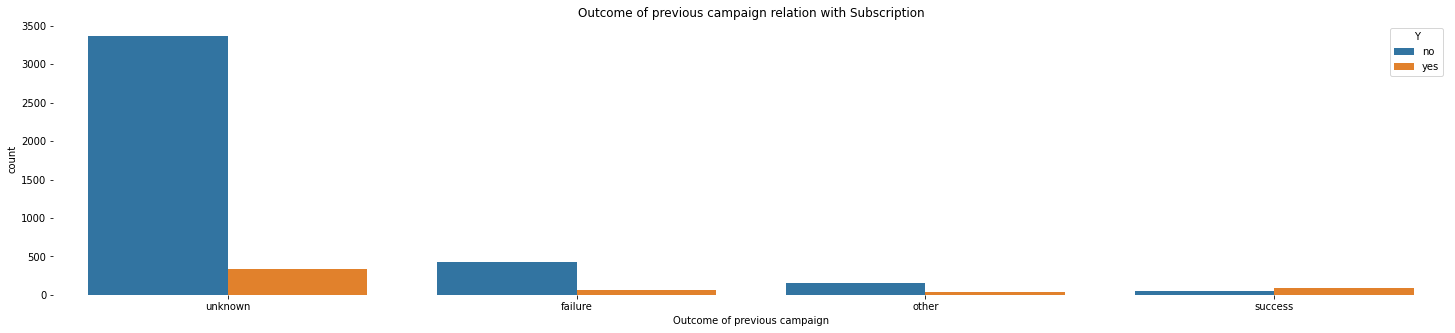

In [0]:
df1=data[['poutcome', 'Y']]
JobCount = df1.groupBy("poutcome","Y").count()
JobCount.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='poutcome', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Outcome of previous campaign', ylabel='count', title = 'Outcome of previous campaign relation with Subscription')

plt.show()

## 5) Check for Data Quality Issues of Numerical Variables

#### I) Understanding "Which Age group" have responded to market campaign.

In [0]:
data.describe('age').show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              4521|
|   mean| 41.17009511170095|
| stddev|10.576210958711263|
|    min|                19|
|    max|                87|
+-------+------------------+



+---+---+-----+
|age|  Y|count|
+---+---+-----+
| 78| no|    2|
| 20| no|    2|
| 56|yes|    6|
| 28|yes|   16|
| 29|yes|   14|
| 71| no|    3|
| 57| no|   88|
| 79|yes|    2|
| 22|yes|    3|
| 42| no|  129|
| 31|yes|   16|
| 59|yes|   13|
| 87|yes|    1|
| 25| no|   34|
| 34|yes|   26|
| 63| no|    5|
| 23|yes|    2|
| 24| no|   20|
| 64| no|    5|
| 32|yes|   28|
+---+---+-----+
only showing top 20 rows



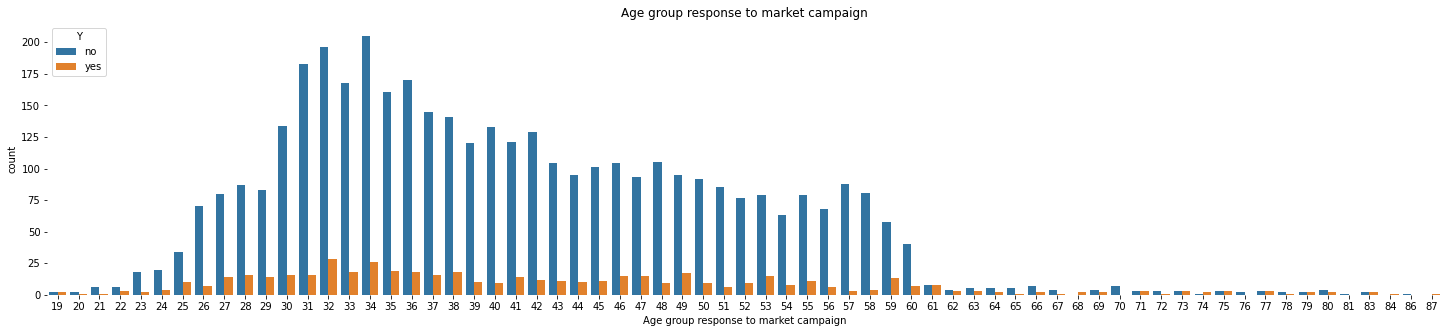

In [0]:
df1=data[['age', 'Y']]
JobCount = df1.groupBy("age","Y").count()
JobCount.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=JobCount.toPandas(), x='age', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Age group response to market campaign', ylabel='count', title = 'Age group response to market campaign')

plt.show()

In [0]:
#Age group between 31 to 36 are most likely to decllined to market campaign

Out[34]: <AxesSubplot:xlabel='age'>

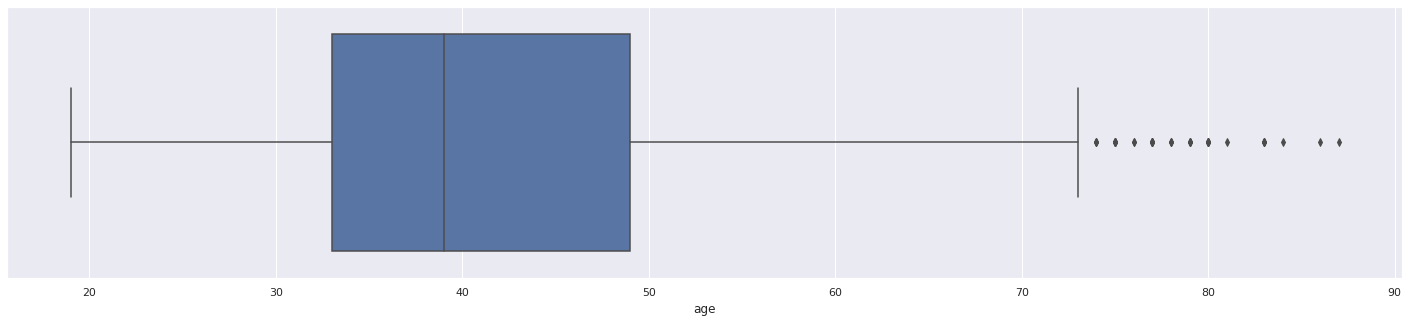

In [0]:
# Now understanding the distribution and finding the outliers.

import seaborn as sns

pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['age'], data=pandas_df)

+---+-----+
|age|count|
+---+-----+
| 31|  199|
| 65|    6|
| 53|   94|
| 78|    3|
| 34|  231|
+---+-----+
only showing top 5 rows



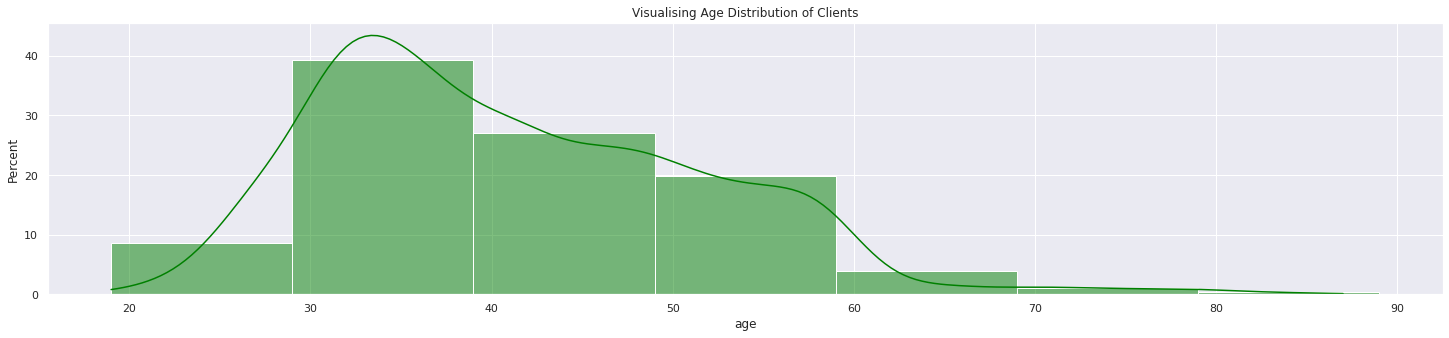

In [0]:
# Distinct Values of the attribute "age" and their number of occurance
AgeCount = data.groupBy("age").count()
AgeCount.show(5) #showing first 5 only
 
#Plotting age histogram
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="age",stat="percent", color = "green", binwidth= 10, kde=True, legend = True).set(title='Visualising Age Distribution of Clients')

In [0]:
# concluding that age > 70 are considered as outlier
#removing outliers that is values less than and equal to 70
data = data.filter(data["age"] <= 70)

+---+-----+
|age|count|
+---+-----+
| 31|  199|
| 65|    6|
| 53|   94|
| 34|  231|
| 28|  103|
+---+-----+
only showing top 5 rows



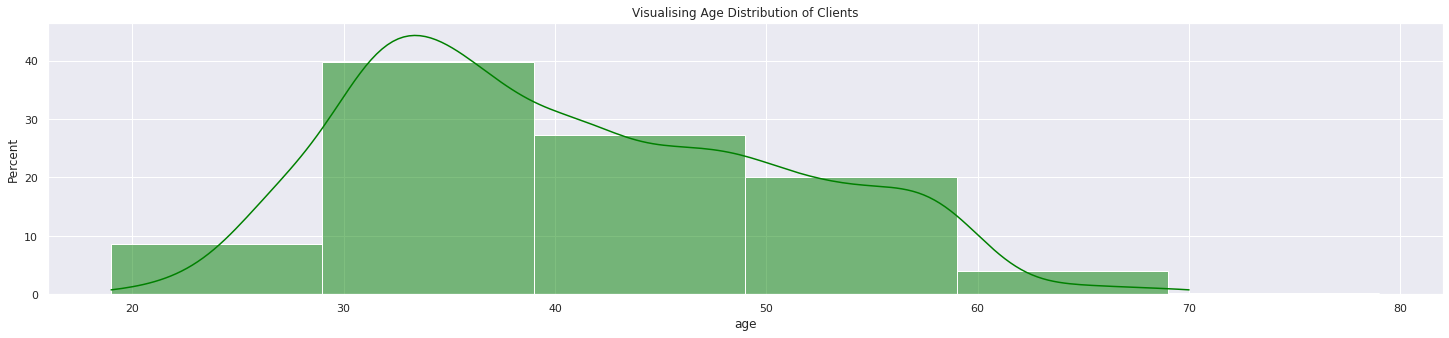

In [0]:
AgeCount = data.groupBy("age").count()
AgeCount.show(5) #showing first 5 only
 
#Plotting age histogram
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="age",stat="percent", color = "green", binwidth= 10, kde=True, legend = True).set(title='Visualising Age Distribution of Clients')

#### J) Understanding "The amount of balance present in the account of consumers" that have been targeted market campaign.

Out[38]: <AxesSubplot:xlabel='balance'>

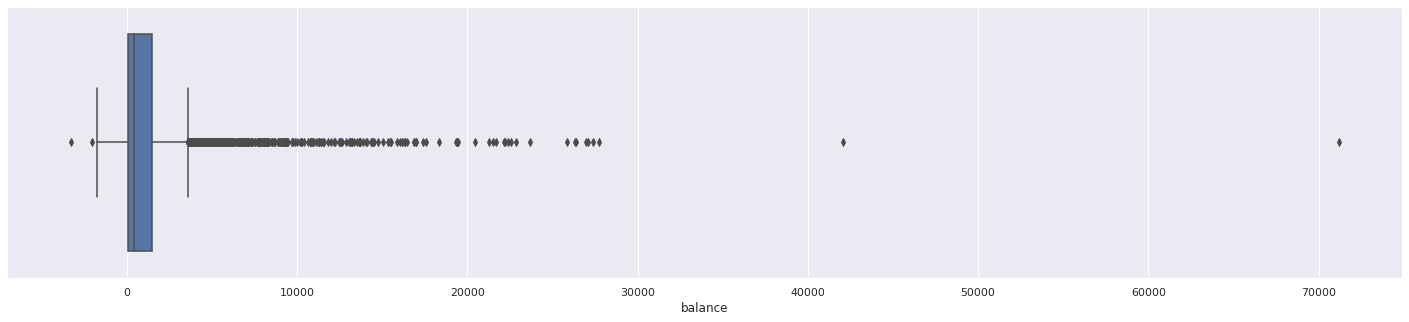

In [0]:
#Plotting boxplot to understand outliers
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['balance'], data=pandas_df)

In [0]:
# Concluding two values are at extreme points that are above >30000
data = data.filter(data["balance"] <= 30000)

Out[40]: <AxesSubplot:xlabel='balance'>

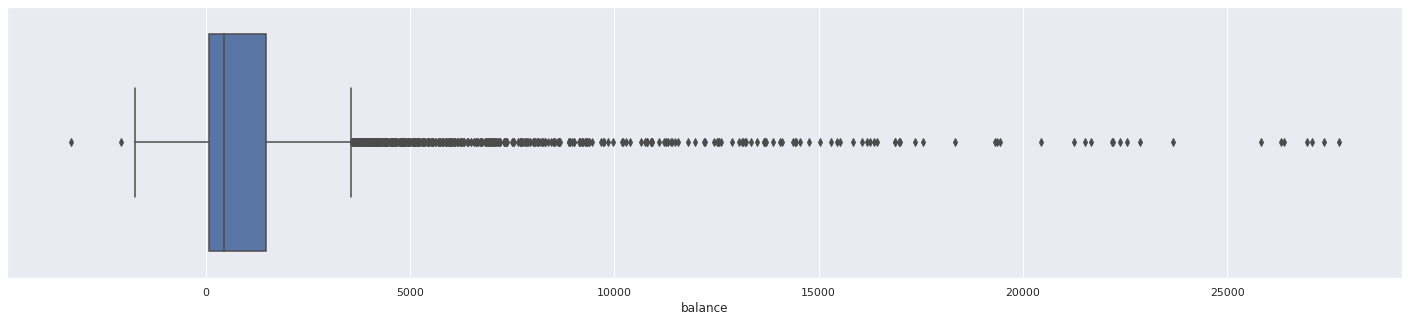

In [0]:
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['balance'], data=pandas_df)

#### K) Understanding "day: last contact day of the month (numeric)" customer contacted for market campaign.

+-------+------------------+
|summary|               day|
+-------+------------------+
|  count|              4465|
|   mean|15.915341545352744|
| stddev| 8.261247344355438|
|    min|                 1|
|    max|                31|
+-------+------------------+

+---+---+-----+
|day|  Y|count|
+---+---+-----+
| 20| no|  241|
| 29|yes|   10|
| 28|yes|   16|
| 22|yes|   14|
| 31|yes|    4|
| 25| no|   70|
| 23|yes|    9|
| 24| no|   26|
| 16|yes|   20|
| 19| no|  183|
|  1| no|   17|
|  1|yes|   10|
| 27| no|   94|
|  5|yes|   27|
| 25|yes|   10|
| 13|yes|   22|
|  2| no|  100|
|  6|yes|   14|
|  9|yes|   14|
| 29| no|  165|
+---+---+-----+
only showing top 20 rows



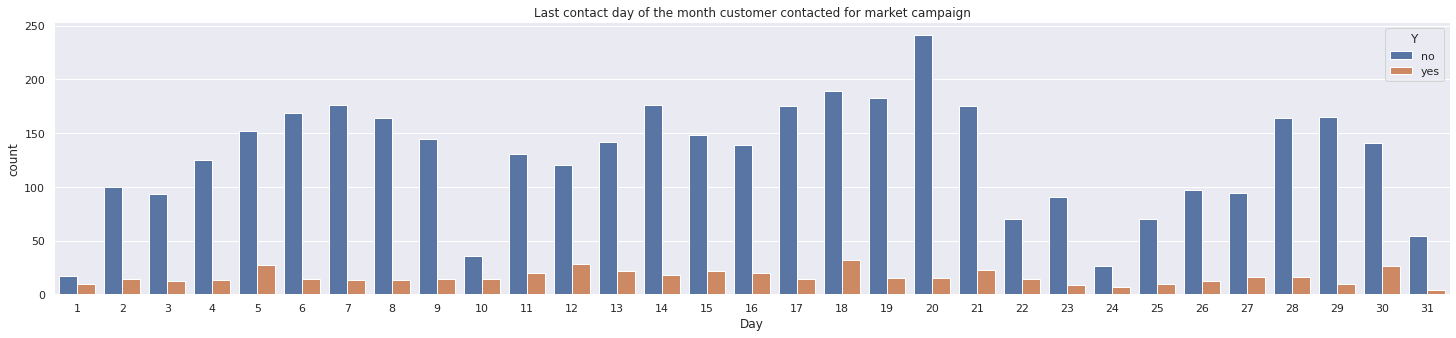

In [0]:
data.describe('day').show()


df1=data[['day', 'Y']]
dayCount = df1.groupBy("day","Y").count()
dayCount.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=dayCount.toPandas(), x='day', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Day', ylabel='count', title = 'Last contact day of the month customer contacted for market campaign')

plt.show()


+---+-----+
|day|count|
+---+-----+
| 31|   58|
| 28|  180|
| 27|  110|
| 26|  109|
| 12|  148|
| 22|   84|
|  1|   27|
| 13|  164|
| 16|  159|
|  6|  183|
+---+-----+
only showing top 10 rows



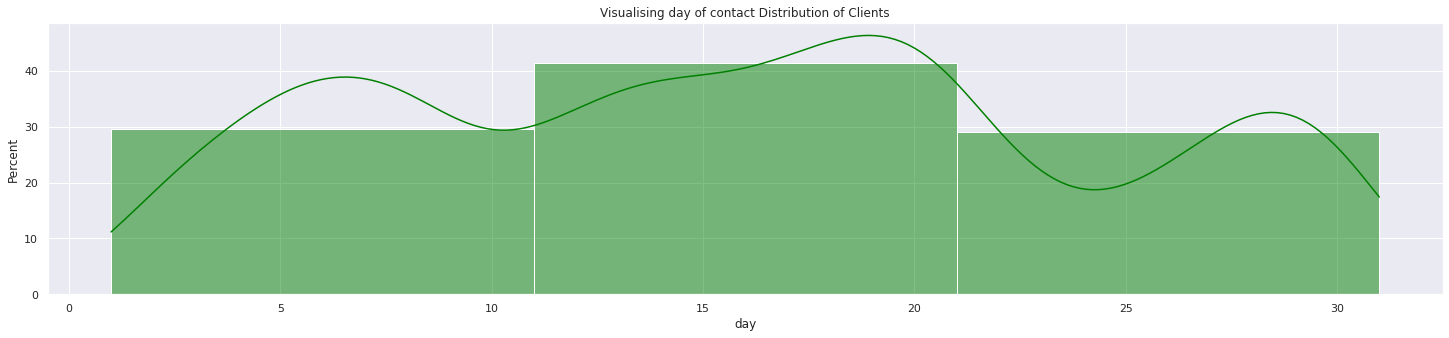

In [0]:
#understanding graph distribution
Count = data.groupBy("day").count()
Count.show(10) #showing first 5 only
 
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="day",stat="percent", color = "green", binwidth= 10, kde=True, legend = True).set(title='Visualising day of contact Distribution of Clients')

Out[43]: <AxesSubplot:xlabel='day'>

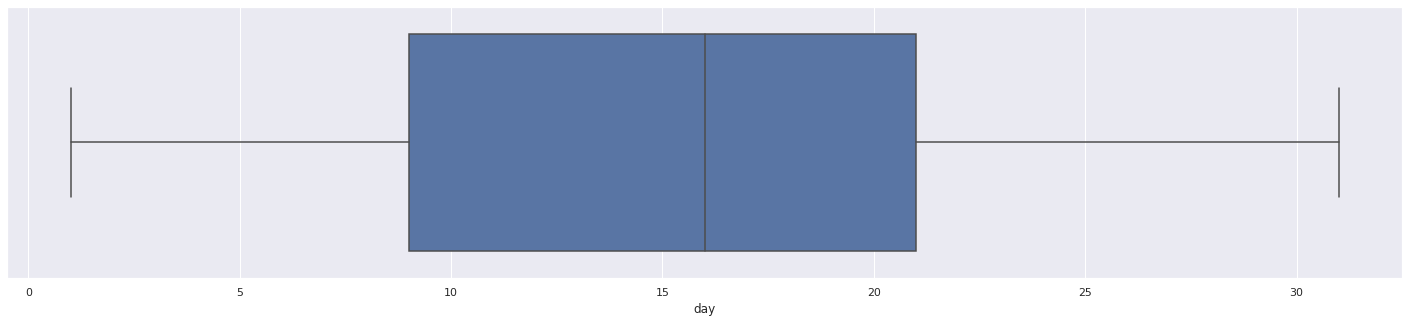

In [0]:
#Plotting boxplot to understand outliers
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['day'], data=pandas_df)

In [0]:
#no outlier found, Alhamdulillah :))

#### L) Understanding "last contact duration (in seconds)" with customer.

+-------+------------------+
|summary|          duration|
+-------+------------------+
|  count|              4465|
|   mean| 262.9010078387458|
| stddev|259.73072984595706|
|    min|                 4|
|    max|              3025|
+-------+------------------+

Out[45]: <AxesSubplot:xlabel='duration'>

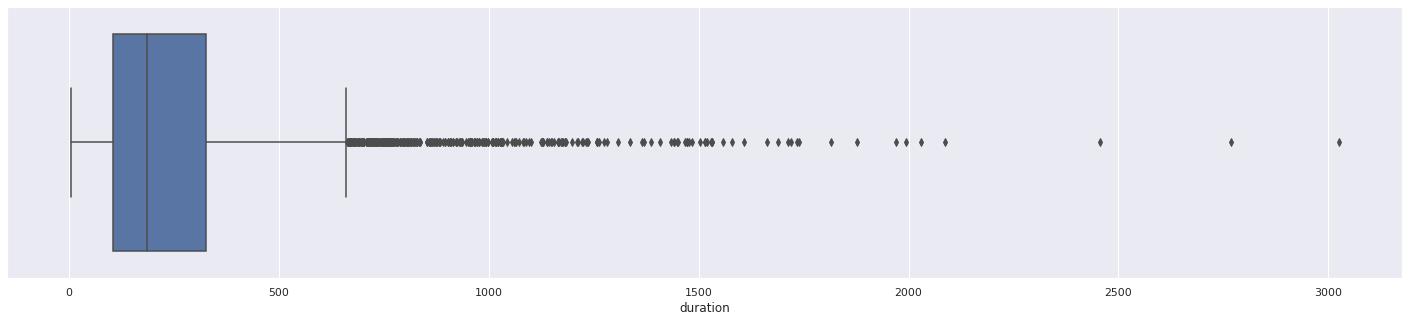

In [0]:

data.describe('duration').show()


#Plotting boxplot to understand outliers
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['duration'], data=pandas_df)

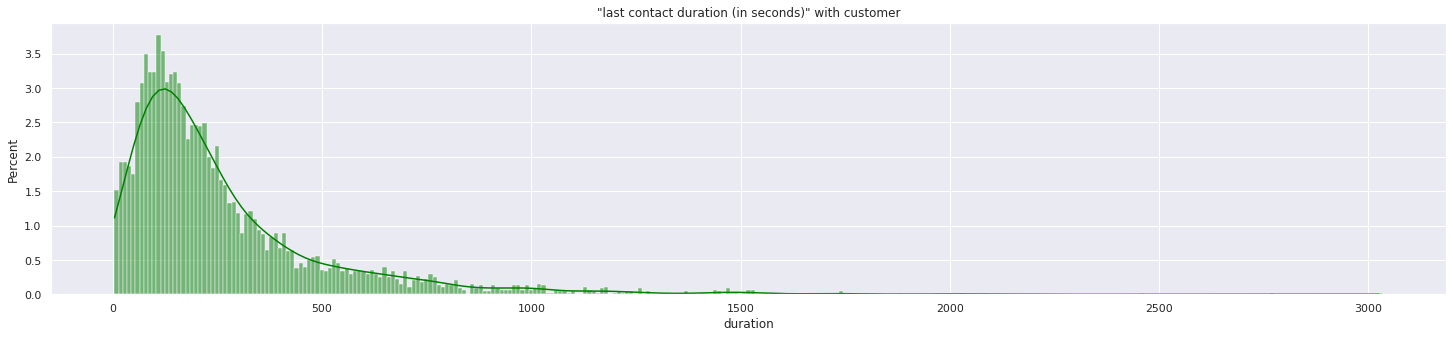

In [0]:
#Plotting histogram
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="duration",stat="percent", color = "green", binwidth= 10, kde=True, legend = True).set(title='"last contact duration (in seconds)" with customer')

In [0]:
# Concluding two values are at extreme points that are above >2000
data = data.filter(data["duration"] <= 2000)

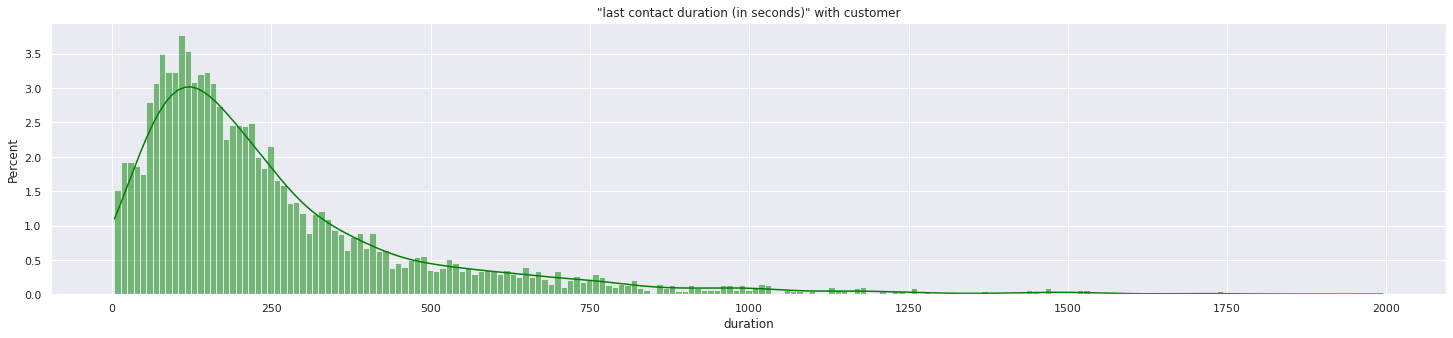

In [0]:
#Plotting again histogram
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="duration",stat="percent", color = "green", binwidth= 10, kde=True, legend = True).set(title='"last contact duration (in seconds)" with customer')

#### M) Understanding "Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)" with customer.

+-------+-----------------+
|summary|         campaign|
+-------+-----------------+
|  count|             4460|
|   mean|2.799775784753363|
| stddev|3.120521451980167|
|    min|                1|
|    max|               50|
+-------+-----------------+

+--------+---+-----+
|campaign|  Y|count|
+--------+---+-----+
|      20| no|    3|
|      25| no|    4|
|      24| no|    2|
|       1| no| 1482|
|       1|yes|  224|
|      19| no|    3|
|       5|yes|    8|
|       2| no| 1115|
|      13|yes|    2|
|       6|yes|   16|
|       9|yes|    2|
|      29| no|    1|
|      44| no|    1|
|       4| no|  280|
|      10| no|   25|
|       7|yes|    5|
|      17|yes|    1|
|      10|yes|    1|
|       9| no|   28|
|      11| no|   22|
+--------+---+-----+
only showing top 20 rows



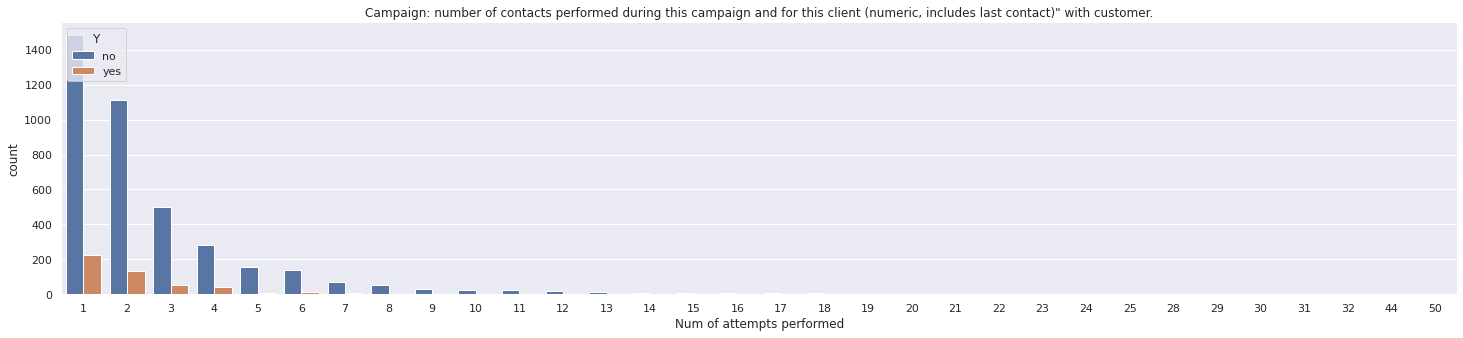

In [0]:
data.describe('campaign').show()


df1=data[['campaign', 'Y']]
Count = df1.groupBy("campaign","Y").count()
Count.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=Count.toPandas(), x='campaign', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Num of attempts performed', ylabel='count', title = "Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)\" with customer.")

plt.show()


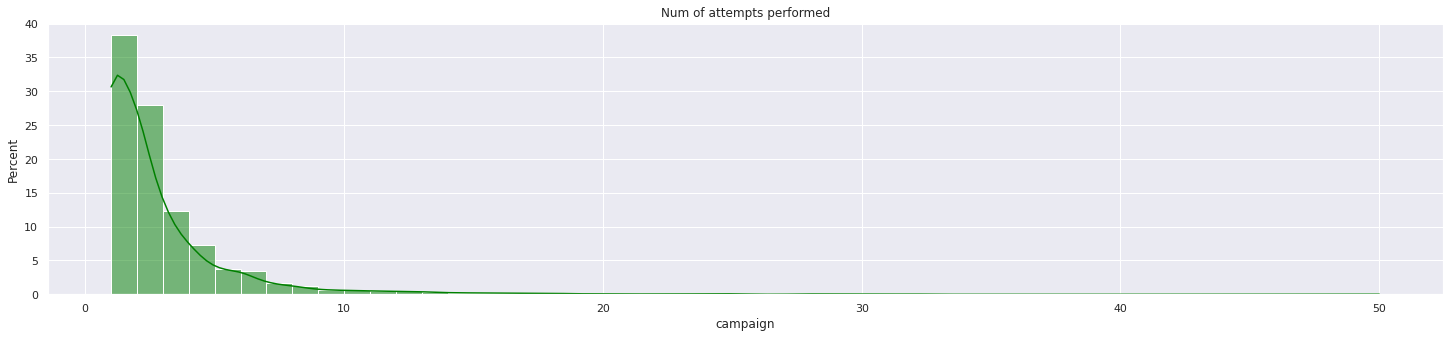

In [0]:
#Plotting again histogram
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="campaign",stat="percent", color = "green", binwidth=1, kde=True, legend = True).set(title='Num of attempts performed')

Out[51]: <AxesSubplot:xlabel='campaign'>

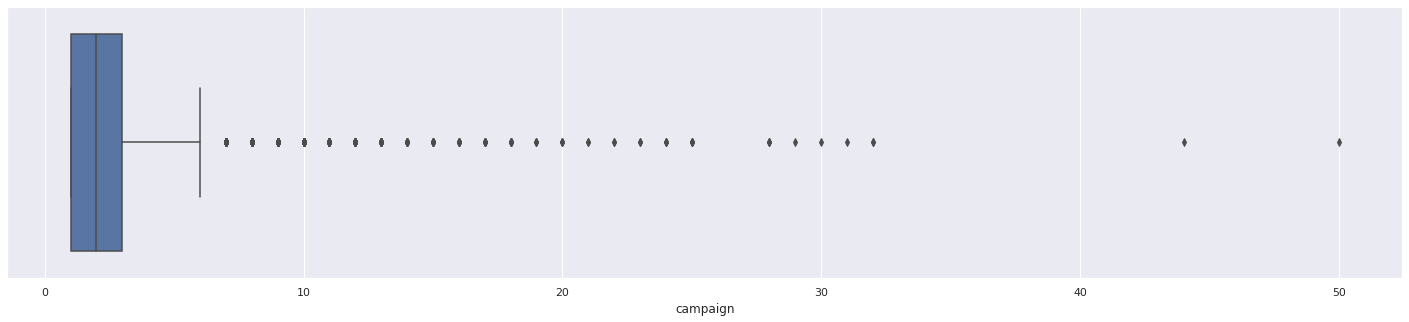

In [0]:
#Plotting boxplot to understand outliers
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['campaign'], data=pandas_df)

In [0]:
# Concluding values which are greater than 27 are consider as outlier
data = data.filter(data["campaign"] <= 27)

Out[53]: <AxesSubplot:xlabel='campaign'>

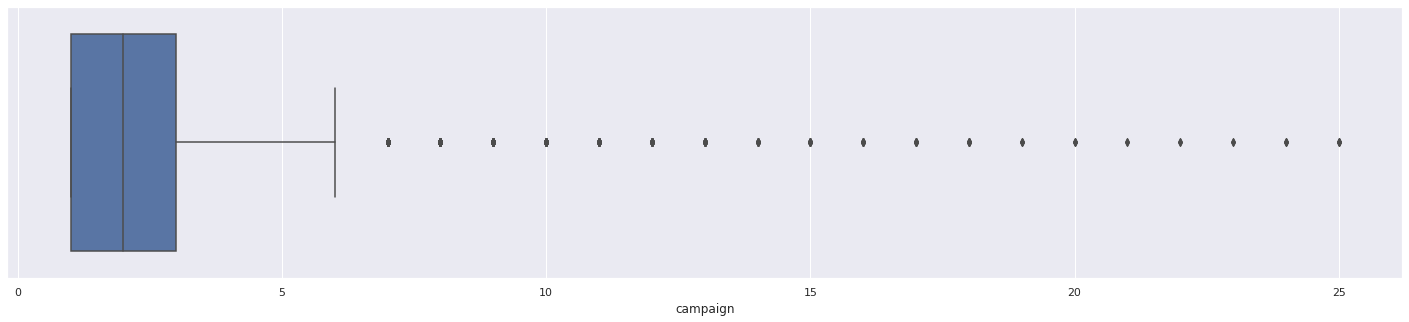

In [0]:
#Again plotting boxplot of campaign
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['campaign'], data=pandas_df)

#### N) Understanding "pdays: number of days that passed by after the client was last contacted from a previous campaign".

Out[54]: <AxesSubplot:xlabel='pdays'>

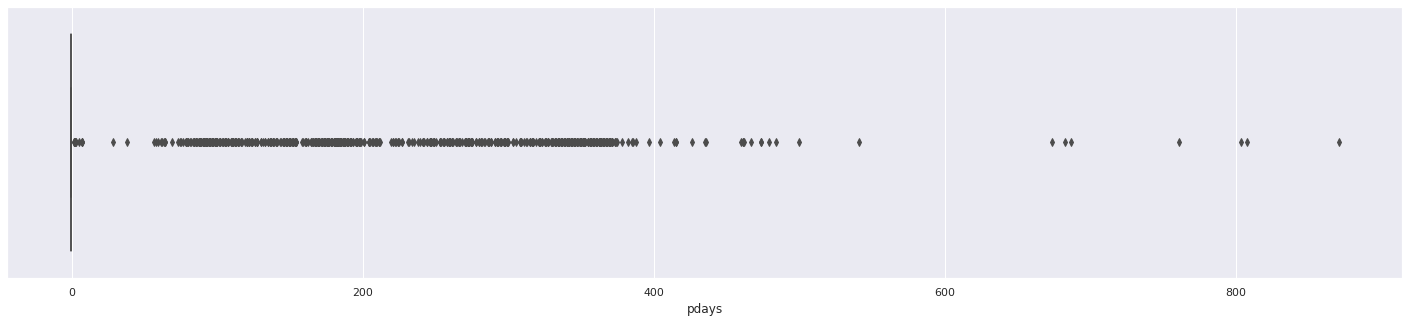

In [0]:
#Plotting boxplot to understand outliers
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['pdays'], data=pandas_df)

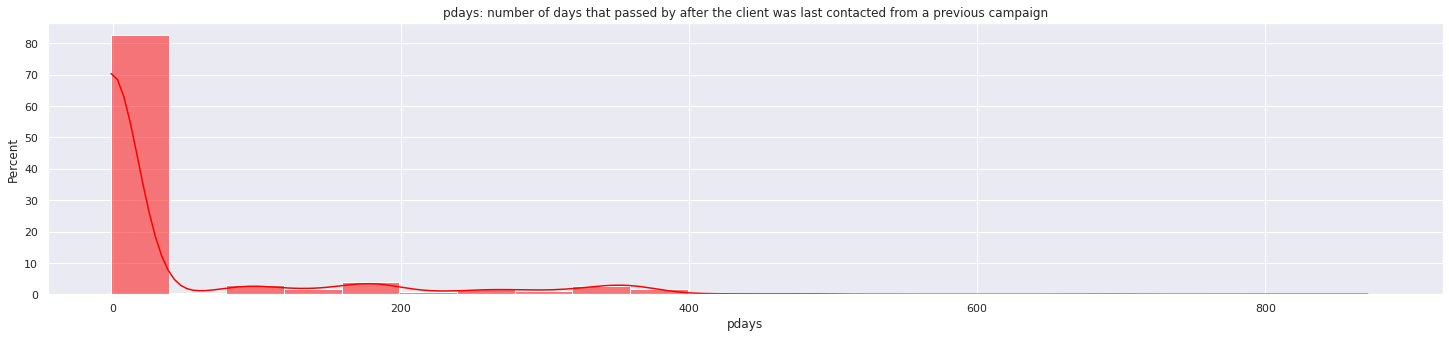

In [0]:
#Plotting again histogram
df_pd = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
age_plot = sns.histplot(data=df_pd, x="pdays",stat="percent", color = "red", binwidth=40, kde=True, legend = True).set(title="pdays: number of days that passed by after the client was last contacted from a previous campaign")

In [0]:
data = data.filter(data["pdays"] <= 600)

Out[57]: <AxesSubplot:xlabel='pdays'>

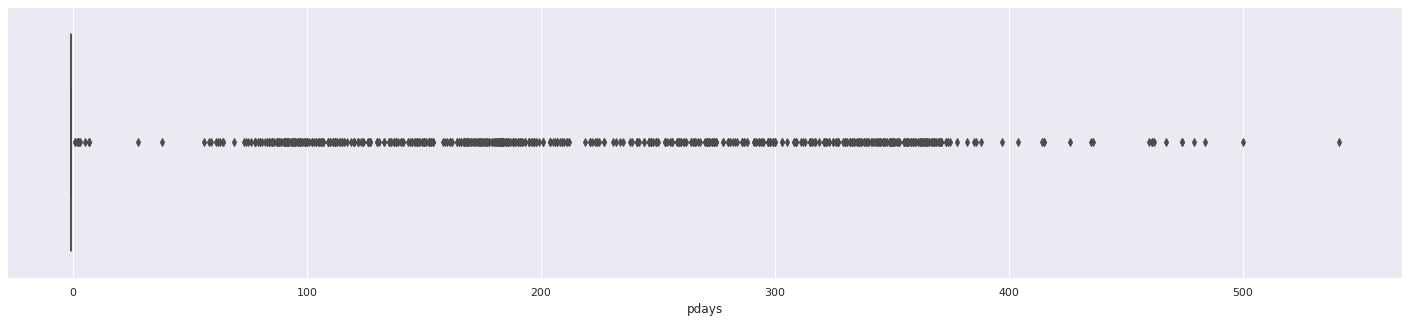

In [0]:
#Again plotting boxplot
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['pdays'], data=pandas_df)

#### O) Understanding "previous: number of contacts performed before this campaign and for this client".

Out[58]: <AxesSubplot:xlabel='previous'>

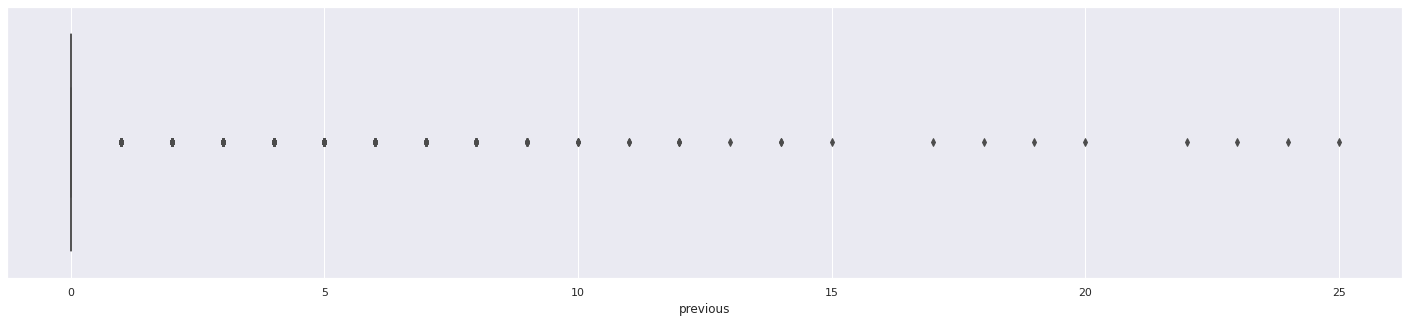

In [0]:
#Plotting boxplot to understand outliers
pandas_df = data.toPandas()
sns.set(rc={'figure.figsize':(25,5)})
sns.boxplot(x=pandas_df['previous'], data=pandas_df)

+-------+------------------+
|summary|          previous|
+-------+------------------+
|  count|              4443|
|   mean|0.5318478505514292|
| stddev|1.6741703496227107|
|    min|                 0|
|    max|                25|
+-------+------------------+

+--------+---+-----+
|previous|  Y|count|
+--------+---+-----+
|      20| no|    1|
|      25| no|    1|
|      24| no|    1|
|       1| no|  232|
|       1|yes|   44|
|      19| no|    1|
|       5|yes|   13|
|       2| no|  139|
|       6|yes|    8|
|       9|yes|    3|
|       4| no|   52|
|      10| no|    2|
|       7|yes|    3|
|      14|yes|    2|
|       0| no| 3336|
|      10|yes|    2|
|       9| no|    7|
|      11| no|    2|
|       6| no|   16|
|      22| no|    1|
+--------+---+-----+
only showing top 20 rows



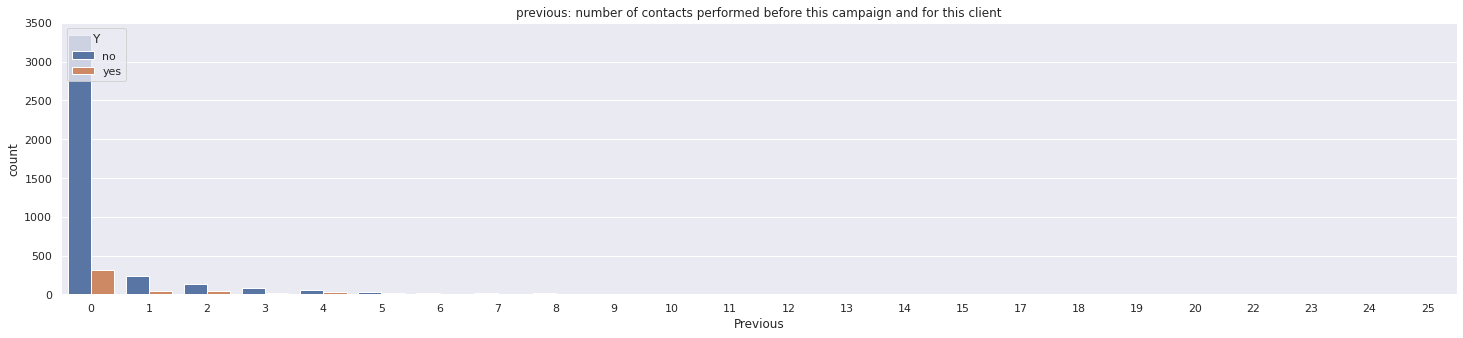

In [0]:
data.describe('previous').show()


df1=data[['previous', 'Y']]
Count = df1.groupBy("previous","Y").count()
Count.show()

f, ax = plt.subplots(figsize = (25,5)) 
sns.barplot(data=Count.toPandas(), x='previous', y='count', hue='Y')
sns.despine(left = True, bottom = True)
ax.set(xlabel='Previous', ylabel='count', title = "previous: number of contacts performed before this campaign and for this client")

plt.show()

## 6) Feature Selection of Categorical variables

In [0]:
# Categorical features are here of two types, Nominal and Ordinal

#### a) Encoding Ordinal Features

In [0]:
from pyspark.sql.functions import when, col

# Create a new DataFrame with a new 'education_num' column
data = data.withColumn("education_num", when(col("education") == "primary", 1)
                                       .when(col("education") == "secondary", 2)
                                       .when(col("education") == "tertiary", 3)
                                       .otherwise(2))



In [0]:
data.head

Out[62]: <bound method DataFrame.head of DataFrame[age: int, job: string, marital: string, education: string, default: string, balance: int, housing: string, loan: string, contact: string, day: int, month: string, duration: int, campaign: int, pdays: int, previous: int, poutcome: string, y: string, education_num: int]>

#### b) Encoding Nominal Features

In [0]:
from pyspark.sql.functions import col

# Create an empty list to store the nominal features
nominal_list = []
ordinal_list =['education']
numerical_list =[]

# Iterate over the columns and their data types
for col_name, data_type in data.dtypes:
    # Check if the data type is 'string' and the column name is not in ordinal_list
    if (data_type == 'string') and (col_name not in ordinal_list):
        # Append the column name to the nominal_list
        nominal_list.append(col_name)
        
    if (data_type == 'int') and (col_name not in ordinal_list):
        numerical_list.append(col_name)

# Print the nominal features
print(nominal_list)
print(f'Number of nominal features: {len(nominal_list)}')

print(numerical_list)


#Obtaining Nominal features

['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Number of nominal features: 9
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 'education_num']


In [0]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *

# Create a list to store the indexed and encoded columns
encoded_cols = []

# Iterate over the nominal_list columns
for column in nominal_list:
    # Create a StringIndexer for the column
    indexer = StringIndexer(inputCol=column, outputCol=column+'_index')
    a=column+'_index'
    # Fit and transform the DataFrame with the StringIndexer
    indexed_data = indexer.fit(data).transform(data)
    # Append the indexed column to the encoded_cols list
    encoded_cols.append(a)
    data = indexed_data
    
#ENCODING CATEGORICAL VARIABLES

In [0]:
from pyspark.sql.functions import col
for i in nominal_list:
    data = data.drop(col(i))
data = data.drop(col("education"))

In [0]:
oridinal_list=['education_num']
from pyspark.sql.functions import col
nominal_data = data.select(*[col(x) for x in encoded_cols])

#Now I am separating all categorical columns from my dataframe :)) 
encoded_cols.append("education_num")

from pyspark.sql.functions import col
categorical_data = data.select(*[col(x) for x in encoded_cols])

categorical_data.show()

+---------+-------------+-------------+-------------+----------+-------------+-----------+--------------+-------+-------------+
|job_index|marital_index|default_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|education_num|
+---------+-------------+-------------+-------------+----------+-------------+-----------+--------------+-------+-------------+
|      8.0|          0.0|          0.0|          1.0|       0.0|          0.0|        8.0|           0.0|    0.0|            1|
|      4.0|          0.0|          0.0|          0.0|       1.0|          0.0|        0.0|           1.0|    0.0|            2|
|      0.0|          1.0|          0.0|          0.0|       0.0|          0.0|        5.0|           1.0|    0.0|            3|
|      0.0|          0.0|          0.0|          0.0|       1.0|          1.0|        3.0|           0.0|    0.0|            3|
|      1.0|          0.0|          0.0|          0.0|       0.0|          1.0|        0.0|           0.0

#### c) Selecting K Best Features based on Chi-Square Test

In [0]:
Y = categorical_data.select(['y_index'])

X = categorical_data.select([col(c) for c in categorical_data.columns if c != 'y_index'])

from pyspark.ml.stat import ChiSquareTest

# Convert X and Y to PySpark DataFrames
X_df = X
Y_df = Y

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import ChiSquareTest

spark=SparkSession.builder.getOrCreate()

assembler = VectorAssembler(
inputCols=X_df.columns,
outputCol="vector-features")

assembler

vectorized_df = assembler.transform(categorical_data).select("y_index", "vector-features")

vectorized_df.show()

+-------+--------------------+
|y_index|     vector-features|
+-------+--------------------+
|    0.0|(9,[0,3,6,8],[8.0...|
|    0.0|(9,[0,4,7,8],[4.0...|
|    0.0|(9,[1,6,7,8],[1.0...|
|    0.0|(9,[4,5,6,8],[1.0...|
|    0.0|(9,[0,5,8],[1.0,1...|
|    0.0|[0.0,1.0,0.0,1.0,...|
|    0.0|(9,[0,7,8],[6.0,2...|
|    0.0| (9,[0,8],[2.0,2.0])|
|    0.0|(9,[0,5,8],[7.0,1...|
|    0.0|[4.0,0.0,0.0,0.0,...|
|    0.0|(9,[0,5,8],[4.0,1...|
|    0.0|(9,[0,6,8],[3.0,5...|
|    0.0|(9,[0,3,6,8],[2.0...|
|    1.0|[10.0,1.0,0.0,1.0...|
|    0.0|[1.0,0.0,0.0,0.0,...|
|    0.0|(9,[3,4,6,8],[1.0...|
|    0.0|(9,[0,3,6,8],[2.0...|
|    0.0|[3.0,1.0,0.0,0.0,...|
|    0.0|(9,[0,1,5,8],[1.0...|
|    0.0|[4.0,0.0,0.0,1.0,...|
+-------+--------------------+
only showing top 20 rows



In [0]:
results = ChiSquareTest.test(vectorized_df,"vector-features","y_index")

In [0]:
results.show()

+--------------------+--------------------+--------------------+
|             pValues|    degreesOfFreedom|          statistics|
+--------------------+--------------------+--------------------+
|[1.30394139467027...|[11, 2, 1, 1, 1, ...|[42.5432905647021...|
+--------------------+--------------------+--------------------+



In [0]:
results = results.toPandas()
Dexter = results['pValues'][0]

from pyspark.ml.linalg import DenseVector
Dexter = Dexter.tolist()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field pValues. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [0]:
Dexter

Out[72]: [1.3039413946702716e-05,
 3.484599932179755e-05,
 0.8193594580325889,
 1.3419976241380027e-10,
 8.157112362905394e-06,
 0.0,
 0.0,
 0.0,
 9.299397983464353e-05]

In [0]:
X_df = categorical_data.select([column for column in categorical_data.columns if column != 'y_index'])

In [0]:
X_df.columns

Out[74]: ['job_index',
 'marital_index',
 'default_index',
 'housing_index',
 'loan_index',
 'contact_index',
 'month_index',
 'poutcome_index',
 'education_num']

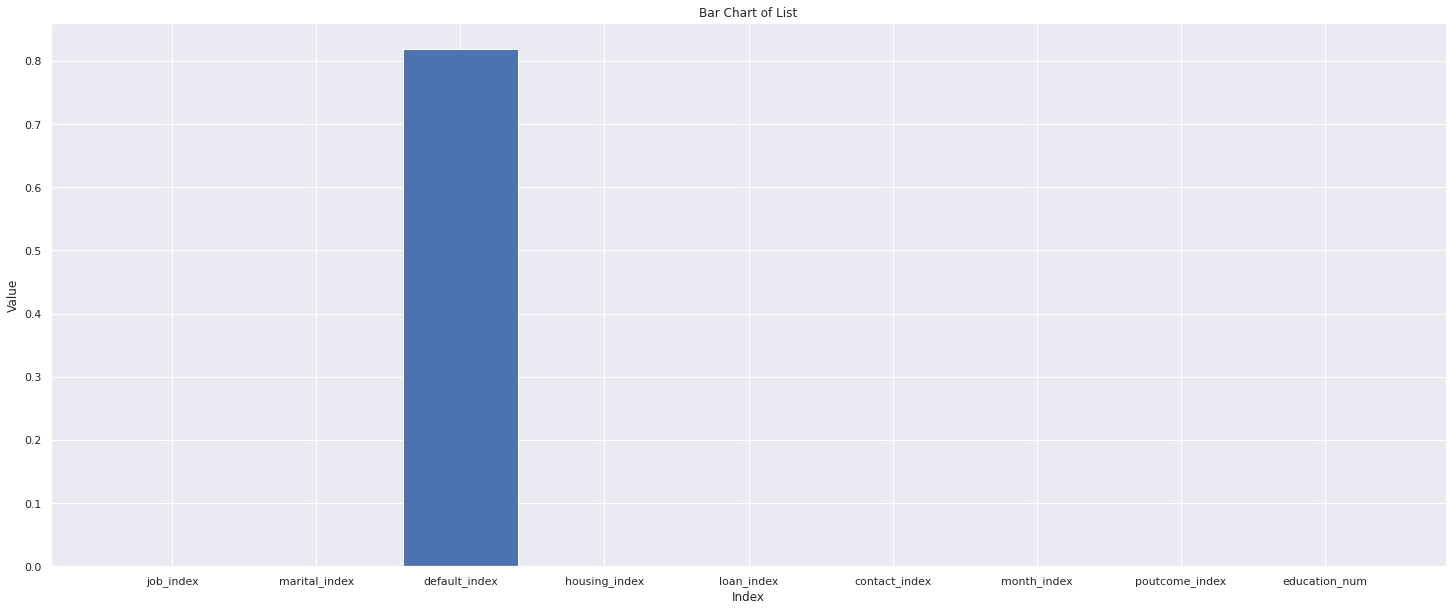

In [0]:
import matplotlib.pyplot as plt

# Create a list of values
values = Dexter

# Create the bar chart
plt.figure(figsize=(25,10))
plt.bar(X_df.columns,Dexter)

# Add labels
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Chart of List')

# Show the chart
plt.show()


In [0]:
#its mean's only "default_index" have high P-value and is need to remove.

## 7) Feature Selection of Numerical variables

In [0]:
#Performing pearson Co-relation to check relationship of numerical variables with target variable

numerical_list.append('y_index')

In [0]:
Numerical_dataframe  = data.select(*[col(x) for x in numerical_list])

In [0]:
Numerical_dataframe.show()

+---+-------+---+--------+--------+-----+--------+-------------+-------+
|age|balance|day|duration|campaign|pdays|previous|education_num|y_index|
+---+-------+---+--------+--------+-----+--------+-------------+-------+
| 30|   1787| 19|      79|       1|   -1|       0|            1|    0.0|
| 33|   4789| 11|     220|       1|  339|       4|            2|    0.0|
| 35|   1350| 16|     185|       1|  330|       1|            3|    0.0|
| 30|   1476|  3|     199|       4|   -1|       0|            3|    0.0|
| 59|      0|  5|     226|       1|   -1|       0|            2|    0.0|
| 35|    747| 23|     141|       2|  176|       3|            3|    0.0|
| 36|    307| 14|     341|       1|  330|       2|            3|    0.0|
| 39|    147|  6|     151|       2|   -1|       0|            2|    0.0|
| 41|    221| 14|      57|       2|   -1|       0|            3|    0.0|
| 43|    -88| 17|     313|       1|  147|       2|            1|    0.0|
| 39|   9374| 20|     273|       1|   -1|       0| 

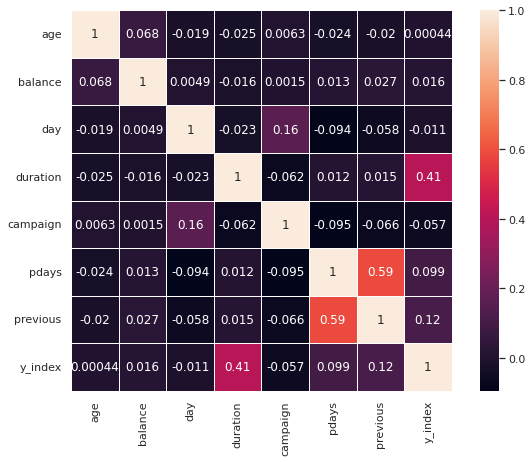

In [0]:
Numerical_dataframe=Numerical_dataframe.drop("education_num")
Numerical_dataframe=Numerical_dataframe.toPandas()
correlation = Numerical_dataframe.corr()
plt.figure(figsize=(10,7))
sns.heatmap(correlation, square=True, annot=True, linewidths=.5);

In [0]:
# We will drop these three feature previous, duration, campaign

## 8) Applying ML Algorithms

In [0]:
Dont_include_these_features = ['previous','duration','campaign','default_index']

for i in Dont_include_these_features:
    data=data.drop(i)

In [0]:
data.show()

+---+-------+---+-----+-------------+---------+-------------+-------------+----------+-------------+-----------+--------------+-------+
|age|balance|day|pdays|education_num|job_index|marital_index|housing_index|loan_index|contact_index|month_index|poutcome_index|y_index|
+---+-------+---+-----+-------------+---------+-------------+-------------+----------+-------------+-----------+--------------+-------+
| 30|   1787| 19|   -1|            1|      8.0|          0.0|          1.0|       0.0|          0.0|        8.0|           0.0|    0.0|
| 33|   4789| 11|  339|            2|      4.0|          0.0|          0.0|       1.0|          0.0|        0.0|           1.0|    0.0|
| 35|   1350| 16|  330|            3|      0.0|          1.0|          0.0|       0.0|          0.0|        5.0|           1.0|    0.0|
| 30|   1476|  3|   -1|            3|      0.0|          0.0|          0.0|       1.0|          1.0|        3.0|           0.0|    0.0|
| 59|      0|  5|   -1|            2|      1.0| 

#### a) K-Means Clustering

In [0]:
from pyspark.ml.clustering import KMeans
 
kmeans_df = data.drop("y_index")
 
vecAssembler = VectorAssembler(inputCols=kmeans_df.columns, outputCol="features")

new_Kmeans_df = vecAssembler.transform(kmeans_df)

new_Kmeans_df.show(2)
 
kmeans = KMeans(k=2, seed=1)
model = kmeans.fit(new_Kmeans_df.select('features'))
transformed = model.transform(new_Kmeans_df)
transformed.show()
 
transformed.groupBy("prediction").count().show()
data.groupBy("y_index").count().show()


+---+-------+---+-----+-------------+---------+-------------+-------------+----------+-------------+-----------+--------------+--------------------+
|age|balance|day|pdays|education_num|job_index|marital_index|housing_index|loan_index|contact_index|month_index|poutcome_index|            features|
+---+-------+---+-----+-------------+---------+-------------+-------------+----------+-------------+-----------+--------------+--------------------+
| 30|   1787| 19|   -1|            1|      8.0|          0.0|          1.0|       0.0|          0.0|        8.0|           0.0|[30.0,1787.0,19.0...|
| 33|   4789| 11|  339|            2|      4.0|          0.0|          0.0|       1.0|          0.0|        0.0|           1.0|[33.0,4789.0,11.0...|
+---+-------+---+-----+-------------+---------+-------------+-------------+----------+-------------+-----------+--------------+--------------------+
only showing top 2 rows

+---+-------+---+-----+-------------+---------+-------------+-------------+------

#### B) Logistic Regression

In [0]:
from pyspark.ml.classification import NaiveBayes 
from pyspark.ml import Pipeline 
from pyspark.ml.feature import StringIndexer
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import BinaryClassificationEvaluator
 
LR_df = data
stages = []
cols = LR_df.columns

#NB_df = NB_df.withColumn("Y", df["Y"].cast(StringType()))
label_stringIdx = StringIndexer(inputCol = 'y_index', outputCol = 'label')
stages = [label_stringIdx]

reg = data.drop("y_index")
vecAssembler = VectorAssembler(inputCols=reg.columns, outputCol="features")
stages += [vecAssembler]

pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(LR_df)
LR_df = pipelineModel.transform(LR_df)
selectedCols = ['label', 'features'] + cols
LR_df = LR_df.select(selectedCols)
#NB_df.show()
 
train, test = LR_df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 3151
Test Dataset Count: 1292


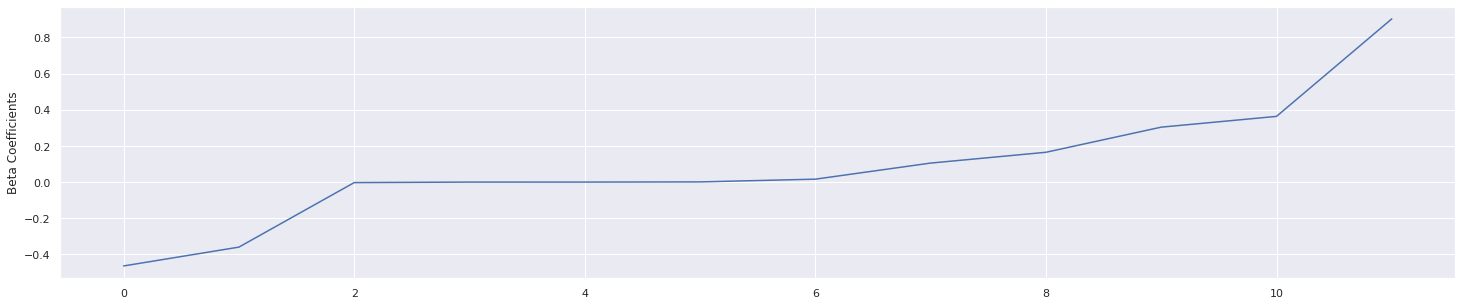

In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
 
import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

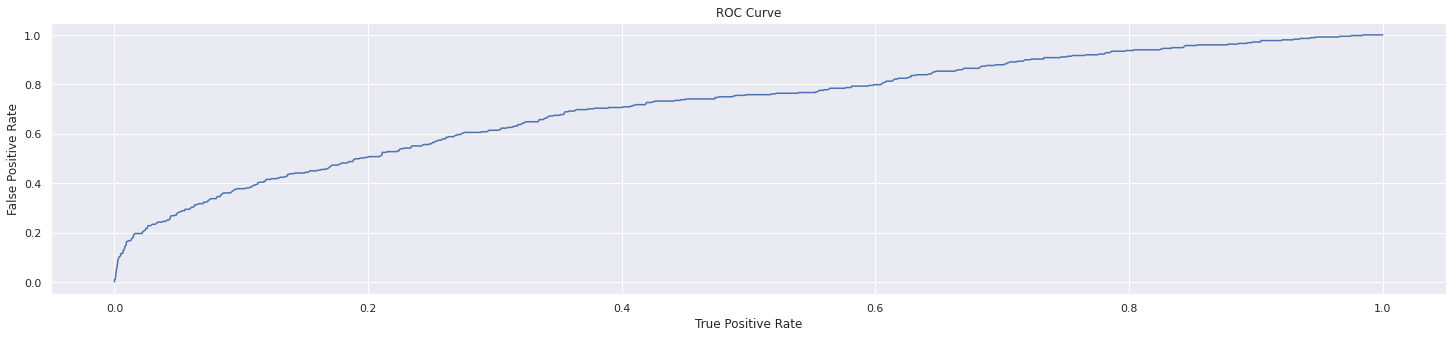

Training set areaUnderROC: 0.7152698697209007


In [0]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

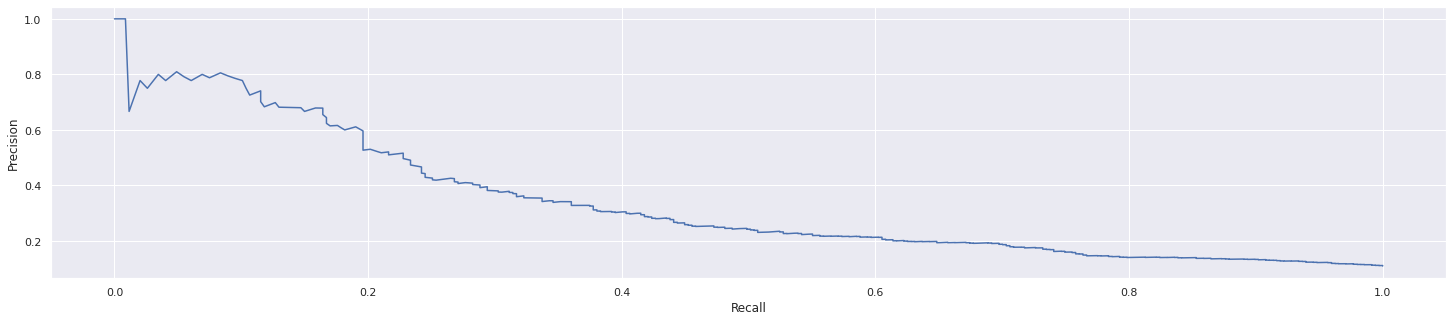

In [0]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [0]:
predictions = lrModel.transform(test)
predictions.select('age', 'job_index', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+---+---------+-----+--------------------+----------+--------------------+
|age|job_index|label|       rawPrediction|prediction|         probability|
+---+---------+-----+--------------------+----------+--------------------+
| 28|      0.0|  0.0|[2.71233576686139...|       0.0|[0.93775063705690...|
| 51|      0.0|  0.0|[2.72096676889816...|       0.0|[0.93825256692676...|
| 54|      0.0|  0.0|[2.71321334506706...|       0.0|[0.93780184546481...|
| 58|      0.0|  0.0|[2.71799396805821...|       0.0|[0.93808011408782...|
| 27|      2.0|  0.0|[2.84773698003684...|       0.0|[0.94520158645077...|
+---+---------+-----+--------------------+----------+--------------------+
only showing top 5 rows



#### B)1)Evaluating logistic regression model performance

In [0]:
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))
 
#The Area Under the ROC curve (AUC) is an aggregated metric that evaluates how well a logistic regression model classifies positive and negative outcomes at all possible cutoffs. It can range from 0.5 to 1, and the larger it is the better. Our results shows better prediction with area under the ROC = 0.86
 
#predictions.groupBy('label', 'prediction').count().show()
 
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label = 1').count()
FP = predictions.filter('prediction = 1 AND label = 0').count()
 
#Calculate the matchine record out of the total records 
accuracy = float((TP+TN) /(TP+TN+FP+FN))
recall = float(TP)/(TP + FN)
precision = float(TP)/(TP + FP)
trueNegRate = float(TN)/(TN + FP)
fscore = 2*(float(precision * recall)/(precision + recall))
 
print("Accuracy : " + str(accuracy))
print("Precision : " + str(precision))
print("Recall : " + str(recall))
print("True Neg Rate : " + str(trueNegRate))
print("F-Score : " + str(fscore))

Test Area Under ROC 0.6901957920234664
Accuracy : 0.8955108359133127
Precision : 0.7222222222222222
Recall : 0.09090909090909091
True Neg Rate : 0.9956483899042646
F-Score : 0.16149068322981366


#### C) Gradient-Boosted Tree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier
 
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job_index', 'label', 'rawPrediction', 'prediction', 'probability').show(5)

+---+---------+-----+--------------------+----------+--------------------+
|age|job_index|label|       rawPrediction|prediction|         probability|
+---+---------+-----+--------------------+----------+--------------------+
| 28|      0.0|  0.0|[0.97553805728484...|       0.0|[0.87556393375061...|
| 51|      0.0|  0.0|[1.02491056666009...|       0.0|[0.88592954398979...|
| 54|      0.0|  0.0|[1.07140056700907...|       0.0|[0.89499415140675...|
| 58|      0.0|  0.0|[1.02491056666009...|       0.0|[0.88592954398979...|
| 27|      2.0|  0.0|[1.04527824545919...|       0.0|[0.88998192576986...|
+---+---------+-----+--------------------+----------+--------------------+
only showing top 5 rows



#### C)1) Evaluating gradient-boosted classifier model performance

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
 
#We tried four algorithms and gradient boosting performed best on our data set.
 
# Calculate the elements of the confusion matrix
TN = predictions.filter('prediction = 0 AND label = prediction').count()
TP = predictions.filter('prediction = 1 AND label = prediction').count()
FN = predictions.filter('prediction = 0 AND label = 1').count()
FP = predictions.filter('prediction = 1 AND label = 0').count()
 
#Calculate the matchine record out of the total records 
accuracy = float((TP+TN) /(TP+TN+FP+FN))
recall = float(TP)/(TP + FN)
precision = float(TP)/(TP + FP)
trueNegRate = float(TN)/(TN + FP)
fscore = 2*(float(precision * recall)/(precision + recall))
 
print("Accuracy : " + str(accuracy))
print("Precision : " + str(precision))
print("Recall : " + str(recall))
print("True Neg Rate : " + str(trueNegRate))
print("F-Score : " + str(fscore))

Test Area Under ROC: 0.743309779863306
Accuracy : 0.8877708978328174
Precision : 0.4642857142857143
Recall : 0.09090909090909091
True Neg Rate : 0.9869451697127938
F-Score : 0.15204678362573099
